In [ ]:
#import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                             roc_auc_score, classification_report, confusion_matrix)
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import joblib
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap

Cell 2: Import Dataset

In [ ]:
# Load the dataset:
df = pd.read_csv(r'data.csv') # change to dataset location

# Fill the missing values:
df.fillna(method="ffill", inplace=True)

Cell 3:
Extract the correct information from the category colum (hypen-seperated values from the first colum)

In [ ]:
# Functions to extract unique files and records for each category:
def find_category(file_name):
    if "-" in file_name:
        return file_name.split("-")[0]
    else:
        return file_name

def find_category_name(file_name):
    if "-" in file_name:
        parts = file_name.split("-")
        return parts[1] if len(parts) > 1 else file_name
    else:
        return file_name

def extract_unique_file_id(file_name):
    return file_name.rsplit('-', 1)[0]

Cell 4:
Create new columns based on above information ( category, category_name, unique_file_id)
Summarise the dataset malware distribution

In [ ]:
# Create new columns:
df["category"] = df["Category"].apply(find_category)
df["category_name"] = df["Category"].apply(find_category_name)
df["unique_file_id"] = df["Category"].apply(extract_unique_file_id)


# Compute unique file counts per malware family and create a summary DataFrame:
unique_counts = df.groupby('category_name')['unique_file_id'].nunique()
total_records = df['category_name'].value_counts()
df_category_summary = pd.DataFrame({
    'Total_Records': total_records,
    'Unique_File_Counts': unique_counts
})
df_category_summary['Percentage'] = (df_category_summary['Total_Records'] / len(df)) * 100
df_category_summary = df_category_summary.reset_index().rename(columns={'index': 'category_name'})
print("Category Summary:")
print(df_category_summary)
df_category_summary.to_csv("df_category_summary.csv", index=False)

Cell 5:
Preprocesses data (encoding labels, splitting into train/validation/test sets).
Trains multiple classifiers using GroupKFold for cross-validation, evaluates them, computes SHAP values, and saves results.

In [ ]:

# ---------------------------------------------------------PREPROCESSING & ENCODING--------------------------------------------------------
meta_cols = ['Category', 'category_name', 'unique_file_id']
df_meta = df[meta_cols].copy()

le_class = LabelEncoder()
le_category = LabelEncoder()
le_catname = LabelEncoder()

df['Class_encoded'] = le_class.fit_transform(df['Class'])
df['category_encoded'] = le_category.fit_transform(df['category'])
df['category_name_encoded'] = le_catname.fit_transform(df['category_name'])

df['group_id'] = df.apply(lambda row: row['unique_file_id'] 
                                    if row['Class'] != 'Benign' 
                                    else f"benign_{row.name}", axis=1)

# Drop columns used for meta or non-numeric:
features = df.drop(columns=[
    'Category', 'Class', 'category', 'category_name',
    'Class_encoded', 'category_encoded', 'category_name_encoded',
    'unique_file_id', 'group_id'
])
target = df['category_name_encoded']


# ----------------------------------------------------------SPLITTING DATA--------------------------------------------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.35, random_state=42)
train_idx, temp_idx = next(gss.split(df, groups=df['group_id']))
train_df = df.iloc[train_idx]
temp_df = df.iloc[temp_idx]

gss_temp = GroupShuffleSplit(n_splits=1, test_size=0.857, random_state=42)
val_idx, test_idx = next(gss_temp.split(temp_df, groups=temp_df['group_id']))
validation_df = temp_df.iloc[val_idx]
test_df = temp_df.iloc[test_idx]

def get_features_and_target(sub_df):
    X = sub_df.drop(columns=[
        'Category', 'Class', 'category', 'category_name', 
        'Class_encoded', 'category_encoded', 'category_name_encoded',
        'unique_file_id', 'group_id'
    ])
    y = sub_df['category_name_encoded']
    return X, y

X_train, y_train = get_features_and_target(train_df)
X_val, y_val = get_features_and_target(validation_df)
X_test, y_test = get_features_and_target(test_df)
feature_cols = X_train.columns.tolist()  # Add this line to define feature_cols
print("Feature columns defined:", feature_cols)  # Optional: verify the columns

meta_val = validation_df[meta_cols].copy()
meta_test = test_df[meta_cols].copy()

total = len(X_train) + len(X_val) + len(X_test)
print("Total records:", total)
print("Train:", len(X_train), f"({round((len(X_train)/total)*100,2)}%)")
print("Test:", len(X_test), f"({round((len(X_test)/total)*100,2)}%)")
print("Validation:", len(X_val), f"({round((len(X_val)/total)*100,2)}%)")


# -------------------------------------------------------CLASSIFIERS & CONFIGURATION--------------------------------------------------
rf_classifier = RandomForestClassifier(
    n_estimators=50, max_depth=5, min_samples_split=4, 
    min_samples_leaf=2, random_state=42
)
knn_classifier = KNeighborsClassifier(n_neighbors=7, weights='distance')
logistic_classifier = LogisticRegression(
    penalty='l2', C=0.5, solver='liblinear', max_iter=1000, random_state=42
)
tree_classifier = DecisionTreeClassifier(
    max_depth=5, min_samples_split=4, min_samples_leaf=2, random_state=42
)
svm_classifier = SVC(
    kernel='rbf', C=0.5, gamma='scale', probability=True, random_state=42
)

# Classifier dictionary (model, scale_required):
classifiers = {
    #'RandomForest': (rf_classifier, False),
   # 'KNN': (knn_classifier, True),
    'LogisticRegression': (logistic_classifier, True),
    #'DecisionTree': (tree_classifier, False),
    #'SVM': (svm_classifier, True)
}

# Hyperparameter grids:
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 75],
        'max_depth': [3, 5, 7],
        'min_samples_split': [4, 6],
        'min_samples_leaf': [2, 3]
    },
    'KNN': {
        'n_neighbors': [7, 9, 11]
    },
    'LogisticRegression': {
        'C': [0.1, 0.5, 1]
    },
    'DecisionTree': {
        'max_depth': [3, 5],
        'min_samples_split': [6, 8],
        'min_samples_leaf': [2, 3]
    },
    'SVM': {
        'C': [0.1, 0.5, 1],
        'kernel': ['rbf']
    }
}

results_dict = {}
shap_values_dict = {}
train_groups = train_df['group_id']

# Encoded value for "Conti":
conti_label = "Conti"
conti_encoded = le_catname.transform([conti_label])[0]

# Lists to collect evaluation metrics and SHAP features:
metrics_list = []
shap_features_list = []

# -------------------------------------------------------TRAINING, EVALUATION & SHAP--------------------------------------------------
for clf_name, (clf_obj, scale_required) in classifiers.items():
    print(f"\nTraining and evaluating {clf_name}...")

    # Build pipeline:
    if scale_required:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf_obj)
        ])
        # GridSearchCV for relevant classifier:
        if clf_name in param_grids:
            grid = {f'clf__{param}': values for param, values in param_grids[clf_name].items()}
            grid_search = GridSearchCV(
                pipeline, grid, cv=GroupKFold(n_splits=5),
                scoring='accuracy', n_jobs=-1
            )
            grid_search.fit(X_train, y_train, groups=train_groups)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
        else:
            best_model = pipeline.fit(X_train, y_train)
    else:
        # No scaling:
        if clf_name in param_grids:
            grid_search = GridSearchCV(
                clf_obj, param_grids[clf_name], cv=GroupKFold(n_splits=5),
                scoring='accuracy', n_jobs=-1
            )
            grid_search.fit(X_train, y_train, groups=train_groups)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
            
        else:
            best_model = clf_obj.fit(X_train, y_train)
    joblib.dump(best_model, f"{clf_name}_AA_model.pkl")
    print(f"Saved model to {clf_name}_AA_model.pkl")


# -------------------------------------------------------Predictions & Metrics--------------------------------------------------------
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)
    
    y_val_pred_labels = le_catname.inverse_transform(y_val_pred)
    y_val_labels = le_catname.inverse_transform(y_val)
    y_test_pred_labels = le_catname.inverse_transform(y_test_pred)
    y_test_labels = le_catname.inverse_transform(y_test)
    
    # Classification report for each class:
    report_dict = classification_report(y_test_labels, y_test_pred_labels, output_dict=True)
    for class_label, scores in report_dict.items():
        if class_label not in ["accuracy", "macro avg", "weighted avg"]:
            metrics_list.append({
                'Classifier': clf_name,
                'Class': class_label,
                'Precision': scores.get('precision', None),
                'Recall': scores.get('recall', None),
                'F1-score': scores.get('f1-score', None),
                'Support': scores.get('support', None)
            })
    
# -------------------------------------------------------SHAP Feature Importance for "Conti"------------------------------------------
    try:
        # If model is wrapped in pipeline, extract the final estimator
        if scale_required:
            model_for_shap = best_model.named_steps['clf']
        else:
            model_for_shap = best_model
        
        # Create a generic SHAP explainer:
        explainer = shap.Explainer(model_for_shap, X_train, feature_names=X_train.columns)
        shap_values = explainer(X_test)
        
        # Store the SHAP values for potential future plotting:
        shap_values_dict[clf_name] = shap_values

        # If multi-class, isolate the "Conti" class:
        if len(shap_values.values.shape) == 3:
            # shape: (n_samples, n_features, n_classes):
            conti_shap = shap_values.values[:, :, conti_encoded]
            mean_shap = np.abs(conti_shap).mean(axis=0)
        else:
            mean_shap = np.abs(shap_values.values).mean(axis=0)
        
        shap_importance = pd.Series(mean_shap, index=X_test.columns).sort_values(ascending=False)
        
        print(f"\nSHAP Feature Importance for '{conti_label}' - {clf_name}:")
        print(shap_importance)
        

        # Plot a bar chart of all features:
        feature_importance = shap_importance
        feature_importance.plot(kind='bar', title=f"SHAP Importance for '{conti_label}' - {clf_name}")
        plt.ylabel('Mean |SHAP value|')
        plt.show()
        
        # Collect all SHAP features for Excel output:
        for feature, shap_val in feature_importance.items():
            shap_features_list.append({
                'Classifier': clf_name, 
                'Feature': feature, 
                'SHAP Importance': shap_val
            })
    
    except Exception as e:
        print(f"SHAP explanation failed for {clf_name}: {e}")
    

# -----------------------------------------------------------Save Test Results--------------------------------------------------------
    if hasattr(best_model, "predict_proba"):
        test_probs = best_model.predict_proba(X_test)
        predicted_probabilities = [round(prob[label] * 100, 2)
                                   for prob, label in zip(test_probs, y_test_pred)]
    else:
        predicted_probabilities = [None] * len(y_test)
    
    results_test_clf = X_test.copy()
    results_test_clf['Actual_Class'] = y_test_labels
    results_test_clf['Predicted_Class'] = y_test_pred_labels
    results_test_clf['Correct'] = results_test_clf['Actual_Class'] == results_test_clf['Predicted_Class']
    results_test_clf['Prediction_Probability'] = predicted_probabilities
    results_test_clf = results_test_clf.merge(meta_test, left_index=True, right_index=True)
    
    csv_filename = f"{clf_name}_Malware_Type_Test_Results.csv"
    results_test_clf.to_csv(csv_filename, index=False)
    
    # Print Validation and Test Reports:
    print(f"\nValidation Set Classification Report for {clf_name}:")
    print(classification_report(y_val_labels, y_val_pred_labels, digits=4))
    print(f"\nTest Set Classification Report for {clf_name}:")
    print(classification_report(y_test_labels, y_test_pred_labels, digits=4))
    
    results_dict[clf_name] = results_test_clf

# -----------------------------------------------------------SAVE RESULTS TO EXCEL----------------------------------------------------
metrics_df = pd.DataFrame(metrics_list)
shap_features_df = pd.DataFrame(shap_features_list)

with pd.ExcelWriter("Classifier_Results.xlsx") as writer:
    metrics_df.to_excel(writer, sheet_name="Metrics", index=False)
    shap_features_df.to_excel(writer, sheet_name="SHAP_Features", index=False)
    
print("\nCombined classification metrics and SHAP feature importances saved to 'Classifier_Results.xlsx'.")

# Save the datasets:
train_df.to_csv("Train_Dataset_Malware_Type.csv", index=False)
validation_df.to_csv("Validation_Dataset_Malware_Type.csv", index=False)
test_df.to_csv("Test_Dataset_Malware_Type.csv", index=False)

Cell 6:
SHAP Summary Plot from above results


Generating SHAP summary plot for LogisticRegression...


C:\Users\MSI\AppData\Local\Temp\ipykernel_21980\371346458.py:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_array, X_test_np, feature_names=feature_names, show=False)


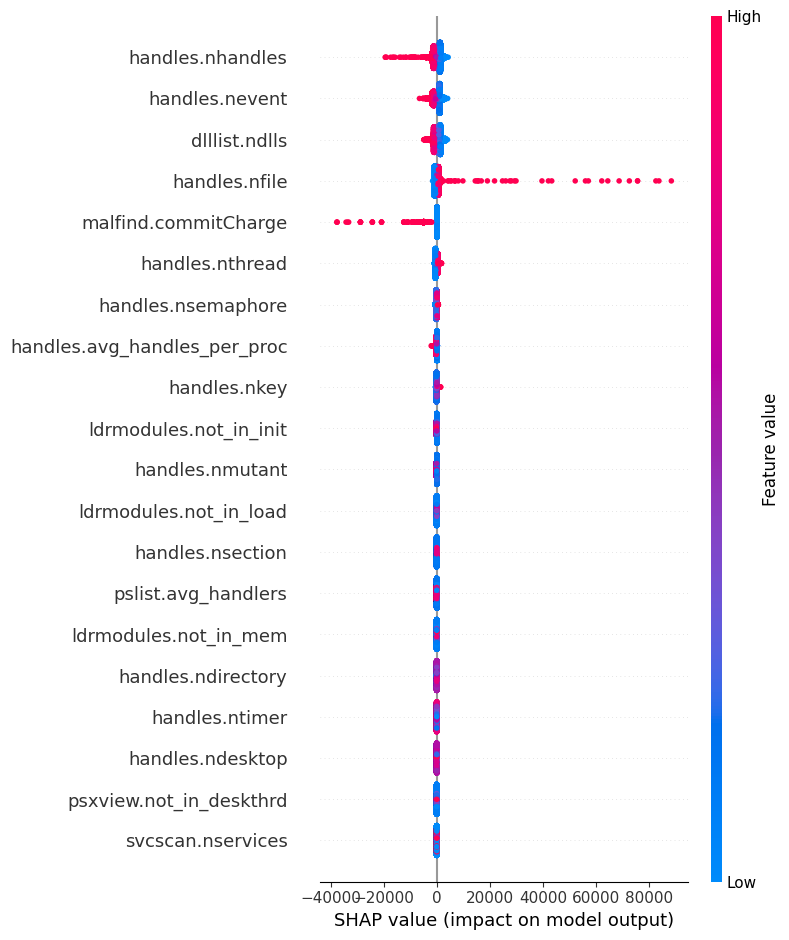

In [17]:

#list_of_classifiers = ["RandomForest", "LogisticRegression", "DecisionTree"]
#iterate over above list to see all results eg:
#for classifier in list_of_classifiers:


# Choose a classifier for SHAP visualization, change this for different models- or iterate over above list:
clf_to_plot = "LogisticRegression"

if clf_to_plot in shap_values_dict:
    shap_values = shap_values_dict[clf_to_plot]

    print(f"\nGenerating SHAP summary plot for {clf_to_plot}...")

    # Convert SHAP Explanation object to NumPy format:
    if isinstance(shap_values, shap.Explanation):
        shap_values_array = shap_values.values
        feature_names = shap_values.feature_names
    else:
        shap_values_array = shap_values
        feature_names = X_test.columns.tolist()

    # Ensure SHAP values are 2D for summary plot:
    if shap_values_array.ndim == 3:
        shap_values_array = shap_values_array[:, :, 0]

    # Convert X_test to NumPy for SHAP compatibility:
    X_test_np = X_test.to_numpy()

    # Add Title to the Plot:
    plt.figure(figsize=(12, 8))
    plt.title(f"SHAP Summary Plot - {clf_to_plot} Model", fontsize=14, fontweight="bold")
    shap.summary_plot(shap_values_array, X_test_np, feature_names=feature_names, show=False)
    plt.show()

else:
    print(f"SHAP values not found for {clf_to_plot}. Ensure training completed successfully.")

 identify top k% of features from the shap analysis add to the critical feature list.



In [10]:
import pandas as pd
import numpy as np

# Load SHAP values from your previous computation
clf_name = "LogisticRegression"  # Adjust based on your target classifier
shap_values = shap_values_dict[clf_name]

# Extract SHAP values for "Conti" class
conti_encoded = le_catname.transform(["Conti"])[0]
if len(shap_values.values.shape) == 3:  # Multi-class case
    conti_shap = shap_values.values[:, :, conti_encoded]
    mean_shap = np.abs(conti_shap).mean(axis=0)
else:  # Binary or unexpected case
    mean_shap = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame of feature importances
feature_names = X_test.columns.tolist()
shap_importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_shap': mean_shap
}).sort_values(by='mean_shap', ascending=False)

# Select top k% features (e.g., k=10)
k = 10
num_features = len(feature_names)
num_critical = int(num_features * (k / 100))
critical_features = shap_importance_df['feature'].head(num_critical).tolist()
print(f"Top {k}% critical features ({num_critical} features):", critical_features)

# Create binary mask: 0 for critical features, 1 for perturbable features
mask = np.ones(len(feature_names))
for feat in critical_features:
    mask[feature_names.index(feat)] = 0

Top 10% critical features (5 features): ['handles.nhandles', 'malfind.commitCharge', 'handles.nevent', 'handles.nfile', 'handles.nsemaphore']


Select 100 conti samples from test dataset, apply FGSM (targeted to benign), with critical features list not modified. 
Output samples to csv.

In [14]:
from art.estimators.classification import SklearnClassifier
import numpy as np
import pandas as pd

def masked_fgsm_attack(classifier, x, y, eps, mask):
    """
    Generate adversarial samples using FGSM with a binary mask.
    
    Parameters:
    - classifier: ART SklearnClassifier object
    - x: Input samples (scaled)
    - y: Target labels
    - eps: Perturbation magnitude
    - mask: Binary mask (1: perturb, 0: preserve)
    
    Returns:
    - Adversarial samples (scaled)
    """
    grad = classifier.loss_gradient(x, y)
    masked_grad = grad * mask
    perturbation = eps * np.sign(masked_grad)
    x_adv = x + perturbation
    return x_adv

# Set random seed for reproducibility
np.random.seed(42)

# Select 100 random Conti samples from test set
conti_indices = test_df[test_df['category_name_encoded'] == conti_encoded].index
selected_indices = np.random.choice(conti_indices, min(100, len(conti_indices)), replace=False)
X_test_conti = X_test.loc[selected_indices]
meta_conti = test_df.loc[selected_indices, ['Category', 'Class', 'category', 'category_name']]

# Load the pre-trained model and scaler
model = joblib.load(f"{clf_name}_AA_model.pkl")
scaler = model.named_steps['scaler']
logistic_clf = model.named_steps['clf']
classifier = SklearnClassifier(model=logistic_clf)

# Scale the samples
X_test_conti_scaled = scaler.transform(X_test_conti)

# Define target as "Benign"
benign_encoded = le_catname.transform(["Benign"])[0]
n_classes = logistic_clf.classes_.shape[0]
y_target_onehot = np.zeros((len(X_test_conti_scaled), n_classes))
y_target_onehot[:, benign_encoded] = 1

# Debug shapes before attack
print("X_test_conti shape:", X_test_conti.shape)
print("X_test_conti_scaled shape:", X_test_conti_scaled.shape)
print("y_target_onehot shape:", y_target_onehot.shape)
print("meta_conti shape:", meta_conti.shape)

# Generate adversarial samples with masked FGSM
eps = 0.1
X_test_adv_scaled = masked_fgsm_attack(classifier, X_test_conti_scaled, y_target_onehot, eps, mask)
X_test_adv_raw = scaler.inverse_transform(X_test_adv_scaled)

# Debug shapes after attack
print("X_test_adv_scaled shape:", X_test_adv_scaled.shape)
print("X_test_adv_raw shape:", X_test_adv_raw.shape)

# Create DataFrame for adversarial samples
X_test_adv_df = pd.DataFrame(X_test_adv_raw, columns=feature_cols, index=selected_indices)
print("X_test_adv_df initial shape:", X_test_adv_df.shape)

# Ensure meta_conti aligns with X_test_adv_df
meta_conti_reset = meta_conti.reset_index(drop=True)
X_test_adv_df = pd.concat([X_test_adv_df.reset_index(drop=True), meta_conti_reset], axis=1)
print("X_test_adv_df final shape:", X_test_adv_df.shape)

# Reorder columns
columns_order = ['Category'] + feature_cols + ['Class', 'category', 'category_name']
X_test_adv_df = X_test_adv_df[columns_order]

# Save to CSV
X_test_adv_df.to_csv("adversarial_fgsm_samples.csv", index=False)
print("Adversarial samples saved to 'adversarial_fgsm_samples.csv'")

# Validation: Check that critical features remain unchanged
for feat in critical_features:
    original_vals = X_test_conti[feat].values
    adv_vals = X_test_adv_df[feat].values
    max_diff = np.max(np.abs(original_vals - adv_vals))
    print(f"Max difference for {feat}: {max_diff}")

X_test_conti shape: (100, 55)
X_test_conti_scaled shape: (100, 55)
y_target_onehot shape: (100, 16)
meta_conti shape: (100, 4)
X_test_adv_scaled shape: (100, 55)
X_test_adv_raw shape: (100, 55)
X_test_adv_df initial shape: (100, 55)
X_test_adv_df final shape: (100, 59)
Adversarial samples saved to 'adversarial_fgsm_samples.csv'
Max difference for handles.nhandles: 0.0
Max difference for malfind.commitCharge: 0.0
Max difference for handles.nevent: 0.0
Max difference for handles.nfile: 0.0
Max difference for handles.nsemaphore: 0.0


In [ ]:
#Perform SHAP analysis using the same LR model, compare the SHAP values for the 100 adversarial samples vs, the original samples

SHAP Value Comparison (Sorted by Mean SHAP Original):
                               Feature  Mean_SHAP_Original  Mean_SHAP_Adversarial
                         handles.nfile          738.584007             738.584007
                      handles.nhandles          692.455825             692.455825
                        handles.nevent          288.210355             288.210355
                  malfind.commitCharge          150.061212             150.061212
                         dlllist.ndlls          112.670327             124.524460
                    handles.nsemaphore          111.988615             111.988615
                      handles.nsection          107.490966             119.571961
                       handles.nmutant           89.849729              98.882704
                       handles.nthread           76.514155              84.134177
                   pslist.avg_handlers           43.164882              53.142359
          handles.avg_handles_per_proc      

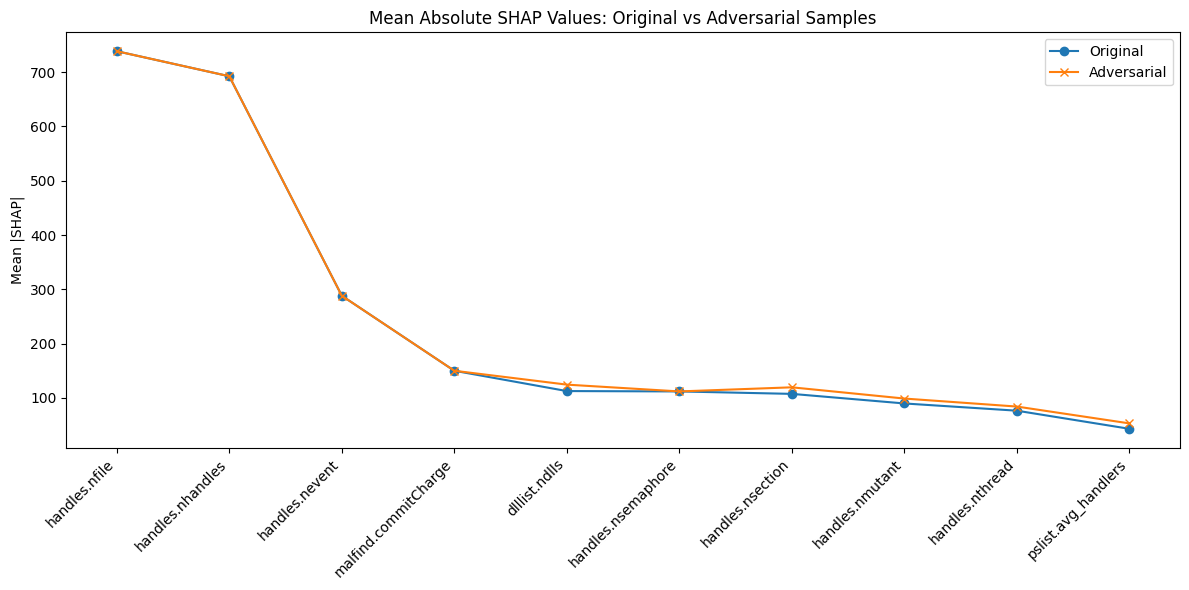

In [16]:
import shap
import numpy as np
import pandas as pd

# Assume the SHAP explainer and data (X_test_conti, X_test_adv_raw) are already defined
# explainer = shap.Explainer(model, X_train)
# feature_cols is a list of feature names corresponding to the dataset

# Step 1: Generate SHAP values for original and adversarial samples
shap_values_original = explainer(X_test_conti)
shap_values_adversarial = explainer(X_test_adv_raw)

# Step 2: Extract SHAP values for the "Conti" class (assuming multi-class case)
conti_encoded = le_catname.transform(["Conti"])[0]  # Label encoder for class "Conti"
shap_original_conti = shap_values_original.values[:, :, conti_encoded]
shap_adversarial_conti = shap_values_adversarial.values[:, :, conti_encoded]

# Step 3: Compute mean absolute SHAP values
mean_shap_original = np.abs(shap_original_conti).mean(axis=0)
mean_shap_adversarial = np.abs(shap_adversarial_conti).mean(axis=0)

# Step 4: Create a DataFrame with feature names and SHAP values
comparison_df = pd.DataFrame({
    'Feature': feature_cols,                  # Feature names
    'Mean_SHAP_Original': mean_shap_original, # Mean SHAP for original samples
    'Mean_SHAP_Adversarial': mean_shap_adversarial  # Mean SHAP for adversarial samples
})

# Step 5: Sort by Mean_SHAP_Original in descending order
comparison_df = comparison_df.sort_values(by='Mean_SHAP_Original', ascending=False)

# Step 6: Display the sorted comparison table with feature names
print("SHAP Value Comparison (Sorted by Mean SHAP Original):")
print(comparison_df.to_string(index=False))

# Step 7: Display the comparison
print("SHAP Value Comparison for All Features:")
print(comparison_df)

# Optional: Save to a file for later use
comparison_df.to_csv('shap_comparison_original_vs_adversarial.csv', index=False)

# Optional: Visualize the top features
top_n = 10  # Adjust as needed
top_features_df = comparison_df.sort_values('Mean_SHAP_Original', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
plt.plot(top_features_df['Feature'], top_features_df['Mean_SHAP_Original'], marker='o', label='Original')
plt.plot(top_features_df['Feature'], top_features_df['Mean_SHAP_Adversarial'], marker='x', label='Adversarial')
plt.xticks(rotation=45, ha='right')
plt.title('Mean Absolute SHAP Values: Original vs Adversarial Samples')
plt.ylabel('Mean |SHAP|')
plt.legend()
plt.tight_layout()
plt.show()